# **Ray**
We'll be using Ray to scale and productionize our ML application.   
We're going to start by initializing Ray inside our notebooks:

In [1]:
import ray
# Initialize Ray	
if ray.is_initialized():
    ray.shutdown()
ray.init()

2025-04-11 22:40:41,383	INFO worker.py:1633 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.11
Ray version:,2.7.0
Dashboard:,http://127.0.0.1:8265


We can also view our cluster resources to view the available compute resources:

In [2]:

ray.cluster_resources()

{'CPU': 12.0,
 'memory': 500298548.0,
 'node:127.0.0.1': 1.0,
 'object_store_memory': 250149273.0,
 'node:__internal_head__': 1.0,
 'GPU': 1.0}

# **2. Data**  


## **2.1 Data Preparation**
Preparing our dataset by ingesting and splitting it.  
We'll start by first preparing our data by ingesting it from source and splitting it into training, validation and test data splits.

### **2.1.1 Ingestion**  
Our data could reside in many different places (databases, files, etc.) and exist in different formats (CSV, JSON, Parquet, etc.). For our application, we'll load the data from a CSV file to a `Pandas DataFrame` using the `read_csv` function.

In [3]:
import pandas as pd

# data ingestion
DATASET_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/dataset.csv"
df = pd.read_csv(DATASET_LOC)
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


### **2.1.2 Splitting**
Next, we need to split our training dataset into train and val data splits.  
* 💠 Use the train split to train the model
* 💠After each iteration (epoch) through the training split, we will use the val split to determine the model's performance.
* 💠Finally, we will use a separate holdout test dataset to determine the model's performance after training.

In [4]:
from sklearn.model_selection import train_test_split
# Value counts
df.tag.value_counts()

tag
natural-language-processing    310
computer-vision                285
other                          106
mlops                           63
Name: count, dtype: int64

For our multi-class task (where each project has exactly one tag), we want to ensure that the data splits have similar class distributions. We can achieve this by specifying how to stratify the split by using the `stratify` keyword argument with sklearn's `train_test_split()` function.  

Creating proper data splits:   
💠the dataset (and each data split) should be representative of data we will encounter  
💠equal distributions of output values across all splits  
💠shuffle your data if it's organized in a way that prevents input variance  
💠avoid random shuffles if your task can suffer from data leaks (ex. time-series)  

In [7]:
# split dataset
test_size = 0.2
train_df, val_df = train_test_split(df, test_size=test_size, stratify=df.tag, random_state=42)

# check the split for class distribution
train_df.tag.value_counts()

tag
natural-language-processing    248
computer-vision                228
other                           85
mlops                           50
Name: count, dtype: int64

In [8]:
# Validation (adjusted) value counts
val_df.tag.value_counts() * int((1-test_size) / test_size)

tag
natural-language-processing    248
computer-vision                228
other                           84
mlops                           52
Name: count, dtype: int64

## **2.2 Exploratory Data Analysis (EDA)**  
Exploratory data analysis (EDA) to understand the signals and nuances of our dataset.  
Here's how to think about EDA:  
💠not just to visualize a prescribed set of plots (correlation matrix, etc.).  
💠goal is to convince yourself that the data you have is sufficient for the task.  
💠use EDA to answer important questions and to make it easier to extract insight  
💠not a one time process; as your data grows, you want to revisit EDA to catch distribution shifts, anomalies, etc


Let's answer a few key questions using EDA.

In [9]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import warnings; warnings.filterwarnings("ignore")
from wordcloud import WordCloud, STOPWORDS

### **2.2.1 Tag Distribution**  
How many data points do we have per tag? We'll use the `Counter` class to get counts for all the different tags

In [10]:
# Most common tags
all_tags = Counter(df.tag)
all_tags.most_common()

[('natural-language-processing', 310),
 ('computer-vision', 285),
 ('other', 106),
 ('mlops', 63)]

We can then separate the tags and from their respective counts and plot them using `Plotly`.

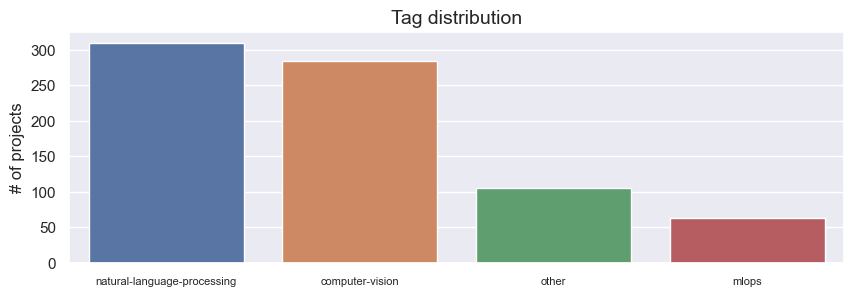

In [11]:
# Plot tag frequencies
tags, tag_counts = zip(*all_tags.most_common())
plt.figure(figsize=(10, 3))
ax = sns.barplot(x=list(tags), y=list(tag_counts))
ax.set_xticklabels(tags, rotation=0, fontsize=8)
plt.title("Tag distribution", fontsize=14)
plt.ylabel("# of projects", fontsize=12)
plt.show()

We do have some data imbalance but it's not too bad.

### **2.2.2 Wordcloud**  
Is there enough signal in the title and description that's unique to each tag? This is important to know because we want to verify our initial hypothesis that the project's title and description are high quality features for predicting the tag. And to visualize this, we're going to use a wordcloud. 

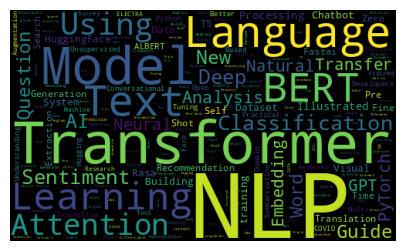

In [12]:
# Most frequent tokens for each tag
tag = "natural-language-processing"
plt.figure(figsize=(10, 3))
subset = df[df.tag == tag]
text =subset.title.values
cloud = WordCloud(
    stopwords=STOPWORDS,
    background_color="black",
    collocations=False,
    width=500, height=300).generate(" ".join(text))
plt.axis("off")	
plt.imshow(cloud)

## **2.3 Data Preprocessing**  
Data preprocessing can be categorized into two types of processes: preparation and transformation. We'll explore common preprocessing techniques and then we'll preprocess our dataset.

### **2.3.1 Preparing**

#### Feature Engineering  
We can combine existing input features to create new meaningful signal for helping the model learn. However, there's usually no simple way to know if certain feature combinations will help or not without empirically experimenting with the different combinations. Here, we could use a project's title and description separately as features but we'll combine them to create one input feature.

In [13]:
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [14]:
# Input
df["text"] = df.title + " " + df.description

#### Cleaning  
Since we're dealing with text data, we can apply some common text preprocessing operations. Here, we'll be using Python's built-in regular expressions library re and the Natural Language Toolkit nltk.

In [15]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\brian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
def clean_text(text, stopwords=STOPWORDS):
    """ Clean Raw Text """
    # lowercase
    text = text.lower()
    
    # remove stopwords
    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub("", text)
    
    # Spacing and Filters
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)  # add spacing
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    text = re.sub(r"http\S+", "", text)  #  remove links
    
    return text



In [17]:
# apply to dataframe
original_df = df.copy()
df.text = df.text.apply(clean_text)
print(f"{original_df.text.values[0]}\n{df.text.values[0]}")

Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


In [18]:
#DataFrame cleanup
df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # drop cols
df = df.dropna(subset=["tag"])  # drop nulls
df = df[["text", "tag"]]  # rearrange cols
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,computer-vision
1,show infer tell contextual inference creative ...,computer-vision
2,awesome graph classification collection import...,other
3,awesome monte carlo tree search curated list m...,other
4,attentionwalk pytorch implementation watch ste...,other


#### **Encoding**
We need to encode our data into numerical values so that our models can process them.  
We'll start by encoding our text labels into unique indices.

In [19]:
# label to index
tags = train_df.tag.unique().tolist()
num_classes = len(tags)
class_to_index = {tag: i for i, tag in enumerate(tags)}
class_to_index

{'natural-language-processing': 0,
 'computer-vision': 1,
 'other': 2,
 'mlops': 3}

In [20]:
## use the map function to map our class_to_index to the tag column
df['tag'] = df['tag'].map(class_to_index)
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,1
1,show infer tell contextual inference creative ...,1
2,awesome graph classification collection import...,2
3,awesome monte carlo tree search curated list m...,2
4,attentionwalk pytorch implementation watch ste...,2


We'll also want to be able to decode our predictions back into text labels. We can do this by creating an index_to_class dictionary and using that to convert encoded labels back into text labels.

In [21]:
def decode(indices, index_to_class):
    return [index_to_class[index] for index in indices]

In [22]:
index_to_class = {v:k for k, v in class_to_index.items()}
decode(df.head()["tag"].values, index_to_class=index_to_class)

['computer-vision', 'computer-vision', 'other', 'other', 'other']

#### **Tokenizer**  
Next we'll encode our text as well. Instead of using a random dictionary, we'll use a tokenizer that was used for a pretrained LLM (scibert) to tokenize our text. We'll be fine-tuning this exact model later when we train our model.  

The tokenizer will convert our input text into a list of token ids and a list of attention masks. The token ids are the indices of the tokens in the vocabulary. The attention mask is a binary mask indicating the position of the token indices so that the model can attend to them (and ignore the pad tokens).

In [23]:
import numpy as np
from transformers import BertTokenizer

In [25]:
# BertTokenizer
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
text = "Transformers are amazing for doing NLP tasks."
encoded_inputs = tokenizer([text], return_tensors="np", padding='longest')
print(f"input_ids: {encoded_inputs['input_ids']}\n")
print(f"attention_mask: {encoded_inputs['attention_mask']}\n")
print(tokenizer.decode(encoded_inputs['input_ids'][0]))

input_ids: [[  102 29155   220 15618   140   168  8328  4588 30121  3574   205   103]]

attention_mask: [[1 1 1 1 1 1 1 1 1 1 1 1]]

[CLS] transformers are amazing for doing nlp tasks. [SEP]


In [26]:
def tokenize(batch):
    tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    encoded_inputs = tokenizer(batch['text'].tolist(),return_tensors="np", padding='longest')
    return dict(ids=encoded_inputs['input_ids'],mask=encoded_inputs['attention_mask'],targets = np.array(batch['tag']))

In [27]:
# Tokenization
tokenize(df.head(1))

{'ids': array([[  102,  2029,  1778,   609,  6446,  4857,  1332,  2399, 13572,
         19125,  1983,  1954,  6240,  3717,  7434,  1262,   537,   201,
          1040,   545,  4714,   103]]),
 'mask': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'targets': array([1], dtype=int64)}

#### Putting it all together!!!

In [28]:
def preprocess(df, class_to_index):
    """Preprocess the data."""
    df["text"] = df.title + " " + df.description  # feature engineering
    df["text"] = df.text.apply(clean_text)  # clean text
    df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # clean dataframe
    df = df[["text", "tag"]]  # rearrange columns
    df["tag"] = df["tag"].map(class_to_index)  # label encoding
    outputs = tokenize(df)
    return outputs

In [29]:
# Apply
preprocess(df=train_df, class_to_index=class_to_index)

{'ids': array([[  102,  6828,  1630, ...,     0,     0,     0],
        [  102,  2570,  7885, ...,     0,     0,     0],
        [  102,  8854,  2998, ...,     0,     0,     0],
        ...,
        [  102,  3526,   318, ...,     0,     0,     0],
        [  102,  1387, 30110, ...,     0,     0,     0],
        [  102, 10850,   142, ...,     0,     0,     0]]),
 'mask': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 'targets': array([0, 0, 0, 0, 0, 1, 0, 1, 2, 1, 0, 0, 1, 2, 2, 1, 3, 1, 2, 0, 1, 1,
        0, 3, 2, 3, 0, 0, 1, 0, 2, 0, 0, 0, 3, 1, 0, 1, 0, 1, 0, 1, 3, 1,
        2, 1, 0, 2, 3, 0, 1, 0, 1, 0, 1, 1, 3, 1, 0, 1, 0, 0, 0, 0, 1, 1,
        0, 0, 1, 1, 1, 0, 0, 1, 1, 3, 1, 1, 1, 2, 0, 0, 3, 1, 2, 0, 0, 0,
        1, 1, 2, 0, 0, 1, 0, 1, 1, 0, 0, 0, 2, 2, 2, 1, 0, 0, 1, 2, 1, 3,
        0, 1, 0, 1, 0, 0, 3, 0, 2,

## **2.4 Distributed Data Processing**  
So far we've performed our data processing operations on a single machine. Our dataset was able to fit into a single Pandas DataFrame and we were able to perform our operations in a single Python process. But what if our dataset was too large to fit into a single machine? We would need to distribute our data processing operations across multiple machines. And with the increasing trend in ML for larger unstructured datasets and larger models (LLMs), we can quickly outgrow our single machine constraints and will need to go distributed.  

we'll be using Ray, a distributed computing framework that makes it easy to scale your Python applications

#### **Setup**
The only setup we have to do is set Ray to preserve order when acting on our data. This is important for ensuring reproducible and deterministic results.

In [30]:
ray.data.DatasetContext.get_current().execution_options.preserve_order = True

#### **Ingestion**
We'll start by ingesting our dataset. 

In [32]:
## Data ingestion

ds = ray.data.read_csv(DATASET_LOC)
ds = ds.random_shuffle(seed=1234)
ds.take(1)

RayTaskError(ModuleNotFoundError): [36mray::_get_reader()[39m (pid=7564, ip=127.0.0.1)
  File "python\ray\_raylet.pyx", line 1616, in ray._raylet.execute_task
  File "c:\Users\brian\miniconda3\envs\madewithml\lib\site-packages\ray\data\read_api.py", line 2348, in _get_reader
    reader = ds.create_reader(**kwargs)
  File "c:\Users\brian\miniconda3\envs\madewithml\lib\site-packages\ray\data\datasource\file_based_datasource.py", line 256, in create_reader
    return _FileBasedDatasourceReader(self, **kwargs)
  File "c:\Users\brian\miniconda3\envs\madewithml\lib\site-packages\ray\data\datasource\file_based_datasource.py", line 476, in __init__
    _check_pyarrow_version()
  File "c:\Users\brian\miniconda3\envs\madewithml\lib\site-packages\ray\data\_internal\util.py", line 78, in _check_pyarrow_version
    from pkg_resources._vendor.packaging.version import parse as parse_version
ModuleNotFoundError: No module named 'pkg_resources._vendor'

In [34]:
# Data ingestion
ds = ray.data.read_csv(DATASET_LOC)
ds = ds.random_shuffle(seed=1234)
ds.take(1)

RayTaskError(ModuleNotFoundError): [36mray::_get_reader()[39m (pid=7564, ip=127.0.0.1)
  File "python\ray\_raylet.pyx", line 1616, in ray._raylet.execute_task
  File "c:\Users\brian\miniconda3\envs\madewithml\lib\site-packages\ray\data\read_api.py", line 2348, in _get_reader
    reader = ds.create_reader(**kwargs)
  File "c:\Users\brian\miniconda3\envs\madewithml\lib\site-packages\ray\data\datasource\file_based_datasource.py", line 256, in create_reader
    return _FileBasedDatasourceReader(self, **kwargs)
  File "c:\Users\brian\miniconda3\envs\madewithml\lib\site-packages\ray\data\datasource\file_based_datasource.py", line 476, in __init__
    _check_pyarrow_version()
  File "c:\Users\brian\miniconda3\envs\madewithml\lib\site-packages\ray\data\_internal\util.py", line 78, in _check_pyarrow_version
    from pkg_resources._vendor.packaging.version import parse as parse_version
ModuleNotFoundError: No module named 'pkg_resources._vendor'